### Imports

In [1]:
import sys
import os
from pathlib import Path

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))
sys.path.append(str(file.parents[1]))
sys.path.append(str(file.parents[2]))

In [2]:
import scipy.ndimage
import torch.nn.functional as F
import monai
import numpy as np
import torch
from TPTBox import NII
from utils.brats_tools import get_central_slice, plot_slices
import utils.fastnumpyio.fastnumpyio as fnio
from data.bids_dataset import create_bids_path_list_of_dicts
import matplotlib.pyplot as plt

In [3]:
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'

train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

## Test Gaussian Filter

### Test Conversions to Soft Mask in a binary scenario

#### Create a sample seg

In [12]:
# Define the dimensions
x, y, z = 20, 20 , 20  # Replace with your desired dimensions

# Create a tensor filled with zeros
circle_tensor = torch.zeros((x, y, z), dtype=torch.long)

# Define the radius of the circle (let's assume a radius of 20)
radius = 5

# Calculate the center of the tensor
center_x, center_y, center_z = x // 2, y // 2, z // 2

# Generate a meshgrid to calculate the distance from the center
X, Y, Z = torch.meshgrid(torch.arange(x), torch.arange(y), torch.arange(z))

# Calculate the distance from the center for each point
distance = torch.sqrt((X - center_x)**2 + (Y - center_y)**2 + (Z - center_z)**2)

# Set ones inside the circle (where the distance is less than the radius)
circle_tensor[distance <= radius] = 1

#One-hot encode the sample segmentation and permute the dimensions
oh_tensor = F.one_hot(circle_tensor, num_classes=2).permute(3, 0, 1, 2)

##### Plotting

Text(0.5, 0.98, 'With One-Hot')

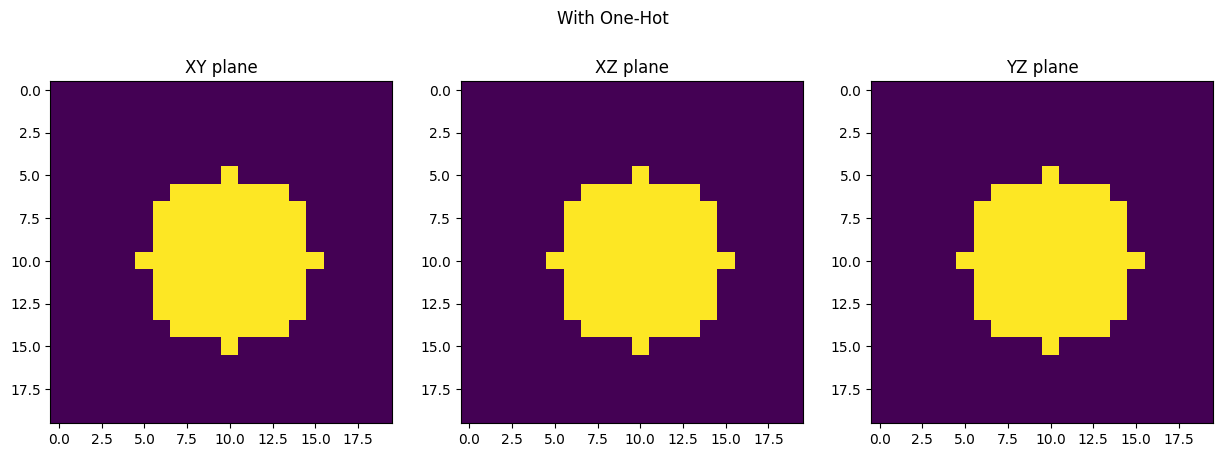

In [10]:
# plot the one-hot encoded map
xy_slice = get_central_slice(oh_tensor, axis = 2)
xz_slice = get_central_slice(oh_tensor, axis = 1)
yz_slice = get_central_slice(oh_tensor, axis = 0)
xy_class_map = torch.argmax(xy_slice, dim=0)
xz_class_map = torch.argmax(xz_slice, dim=0)
yz_class_map = torch.argmax(yz_slice, dim=0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_class_map)
ax[0].set_title('XY plane')
ax[1].imshow(xz_class_map)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_class_map)
ax[2].set_title('YZ plane')
plt.suptitle('With One-Hot')

#### Try a Gaussian Filter on one-hot encoded

##### Create and apply filter

In [20]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 1  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_tensor = torch.empty_like(oh_tensor, dtype=torch.float32)  # Create an empty tensor to store the results

for i in range(oh_tensor.shape[0]):  # Loop through each class channel
    filtered_oh_tensor[i] = torch.tensor(scipy.ndimage.gaussian_filter(oh_tensor[i].numpy().astype(float), sigma=sigma))


print(filtered_oh_tensor.shape)  # Should still be (2, x, y, z)
print(filtered_oh_tensor)
print(f"np.unique(filtered_tensor): {np.unique(filtered_oh_tensor)}")
print(f"np.unique(one_hot_tensor): {np.unique(oh_tensor)}")
print(f"filtered_oh_tensor[:,7,15,10]: {filtered_oh_tensor[:,7,15,10]}")

torch.Size([2, 20, 20, 20])
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         ...,

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
         

##### Plot slices channelwise, to visualize the "probablities' of each class

Text(0.5, 1.0, 'YZ plane')

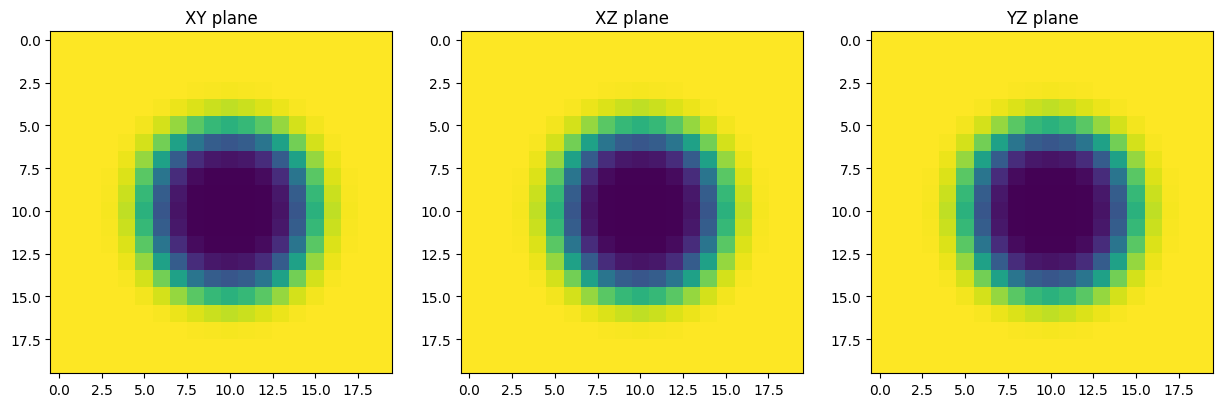

In [21]:
first_channel = filtered_oh_tensor[0]

xy_slice = get_central_slice(first_channel, axis = 2)
xz_slice = get_central_slice(first_channel, axis = 1)
yz_slice = get_central_slice(first_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

Text(0.5, 1.0, 'YZ plane')

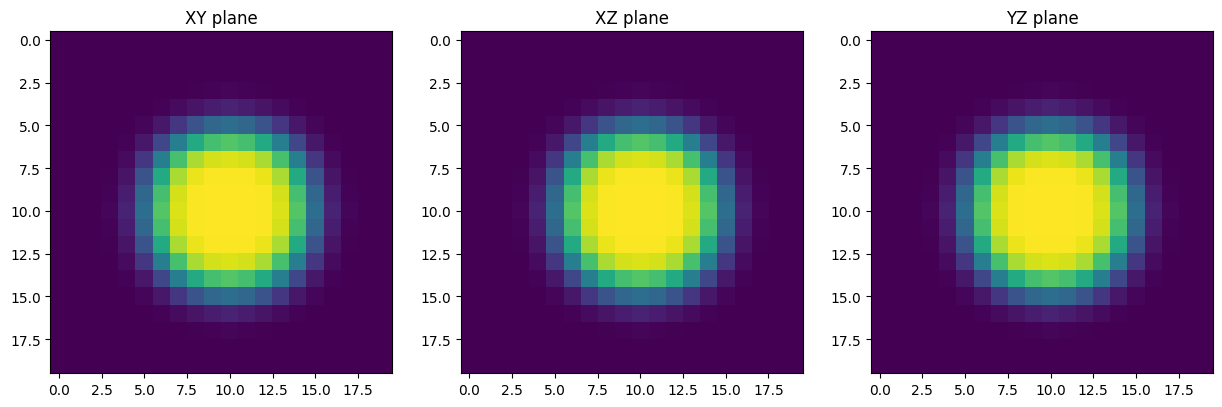

In [22]:
sec_channel = filtered_oh_tensor[1]

xy_slice = get_central_slice(sec_channel, axis = 2)
xz_slice = get_central_slice(sec_channel, axis = 1)
yz_slice = get_central_slice(sec_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

### Test softening with multi classes

#### Create sample seg with 4 classes

In [84]:
# Define the dimensions
x, y, z = 100, 100 , 100  # Replace with your desired dimensions

# Create a tensor filled with zeros
circle_tensor = torch.zeros((x, y, z), dtype=torch.long)

# Define the radius' of the circles (let's assume a radius of 20)
radius_c3 = 5
radius_c2 = 20
radius_c1 = 40

# Calculate the center of the tensor
center_x, center_y, center_z = x // 2, y // 2, z // 2

# Generate a meshgrid to calculate the distance from the center
X, Y, Z = torch.meshgrid(torch.arange(x), torch.arange(y), torch.arange(z))

# Calculate the distance from the center for each point
distance = torch.sqrt((X - center_x)**2 + (Y - center_y)**2 + (Z - center_z)**2)

# Set ones inside the circle (where the distance is less than the radius)
circle_tensor[distance <= radius_c1] = 1
circle_tensor[distance <= radius_c2] = 2
circle_tensor[distance <= radius_c3] = 3

print(f"circle_tensor.shape: {circle_tensor.shape}")  # Should be (x,y,z)
print(f"np.unique(circle_tensor): {np.unique(circle_tensor)}")

#One-hot encode the sample segmentation
oh_tensor = F.one_hot(circle_tensor, num_classes=4).permute(3, 0, 1, 2)

print(f"oh_tensor.shape: {oh_tensor.shape}")  # Should be (4, x, y, z)
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")

circle_tensor.shape: torch.Size([100, 100, 100])
np.unique(circle_tensor): [0 1 2 3]
oh_tensor.shape: torch.Size([4, 100, 100, 100])
np.unique(oh_tensor): [0 1]


##### Plot one-hot encoded

Text(0.5, 0.98, 'With One-Hot')

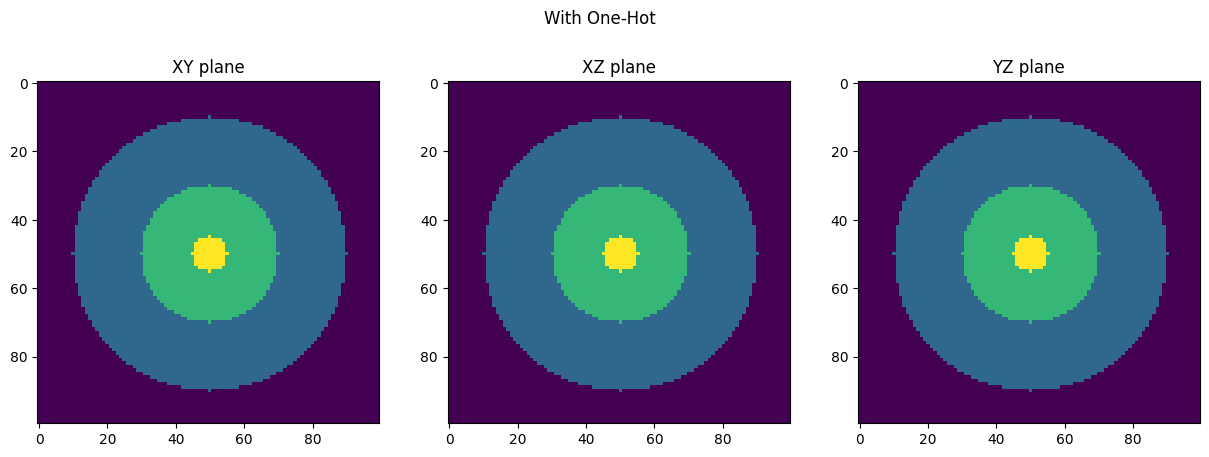

In [85]:
# plot the one-hot encoded map
xy_slice = get_central_slice(oh_tensor, axis = 2)
xz_slice = get_central_slice(oh_tensor, axis = 1)
yz_slice = get_central_slice(oh_tensor, axis = 0)
xy_class_map = torch.argmax(xy_slice, dim=0)
xz_class_map = torch.argmax(xz_slice, dim=0)
yz_class_map = torch.argmax(yz_slice, dim=0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_class_map)
ax[0].set_title('XY plane')
ax[1].imshow(xz_class_map)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_class_map)
ax[2].set_title('YZ plane')
plt.suptitle('With One-Hot')

#### Try Gaussian on multi-class one-hot

In [86]:
print(f"oh_tensor.shape: {oh_tensor.shape}")  # Should be (4, x, y, z)
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")
print(f"oh_tensor: {oh_tensor}")

oh_tensor.shape: torch.Size([4, 100, 100, 100])
np.unique(oh_tensor): [0 1]
oh_tensor: tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         ...,

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
    

In [87]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 1  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_tensor = torch.empty_like(oh_tensor, dtype=torch.float32)  # Create an empty tensor to store the results

for i in range(oh_tensor.shape[0]):  # Loop through each class channel
    filtered_oh_tensor[i] = torch.tensor(scipy.ndimage.gaussian_filter(oh_tensor[i].numpy().astype(float), sigma=sigma))


print(filtered_oh_tensor.shape)  # Should still be (4, x, y, z)
print(f"np.unique(filtered_tensor): {np.unique(filtered_oh_tensor)}")
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")

torch.Size([4, 100, 100, 100])
np.unique(filtered_tensor): [0.0000000e+00 2.3969917e-12 4.7939834e-12 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
np.unique(oh_tensor): [0 1]


##### Plot slices channelwise, to visualize the "probablities' of each class

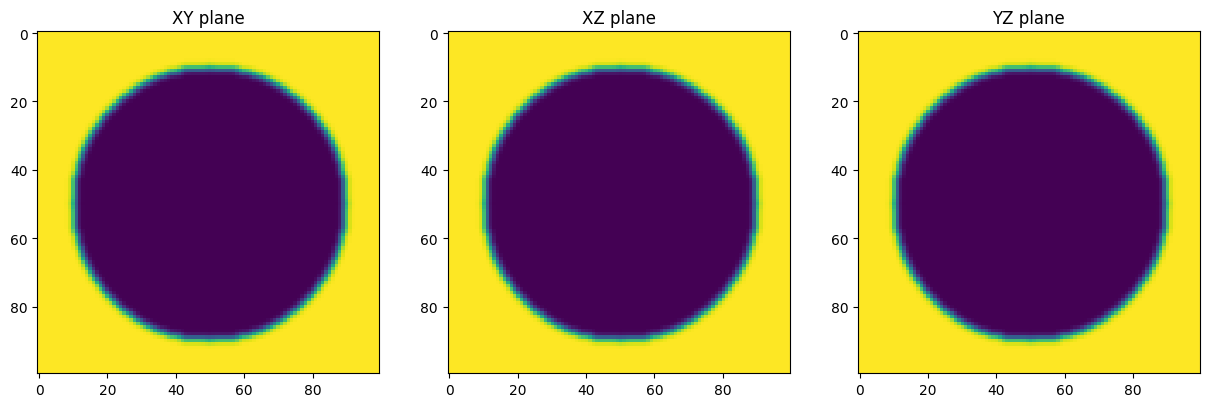

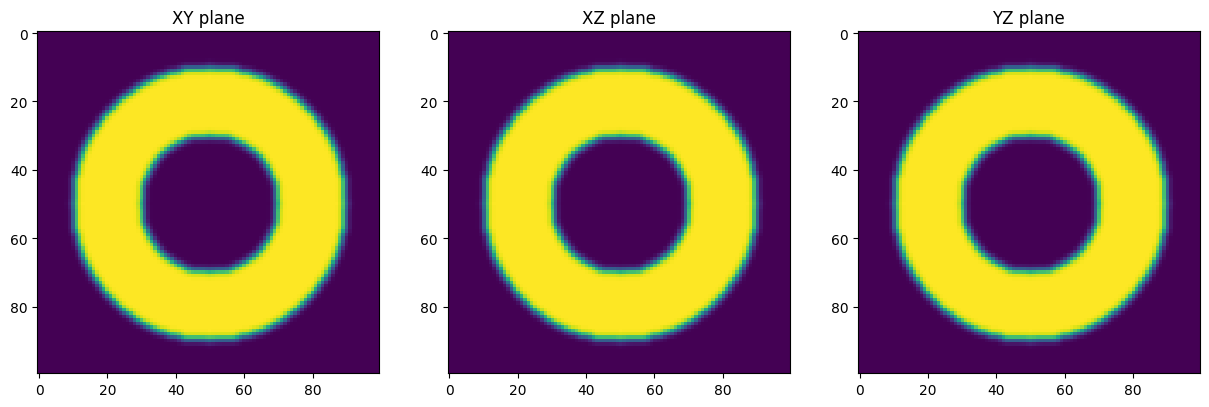

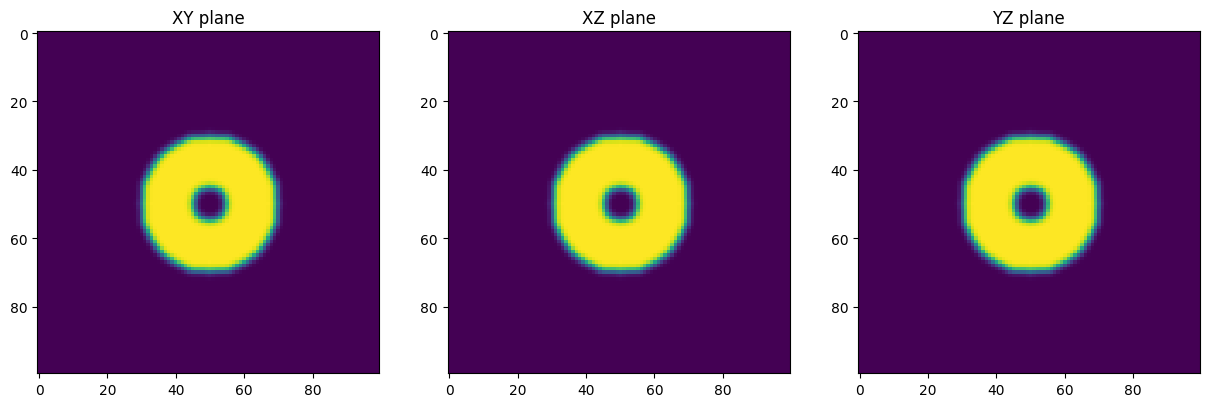

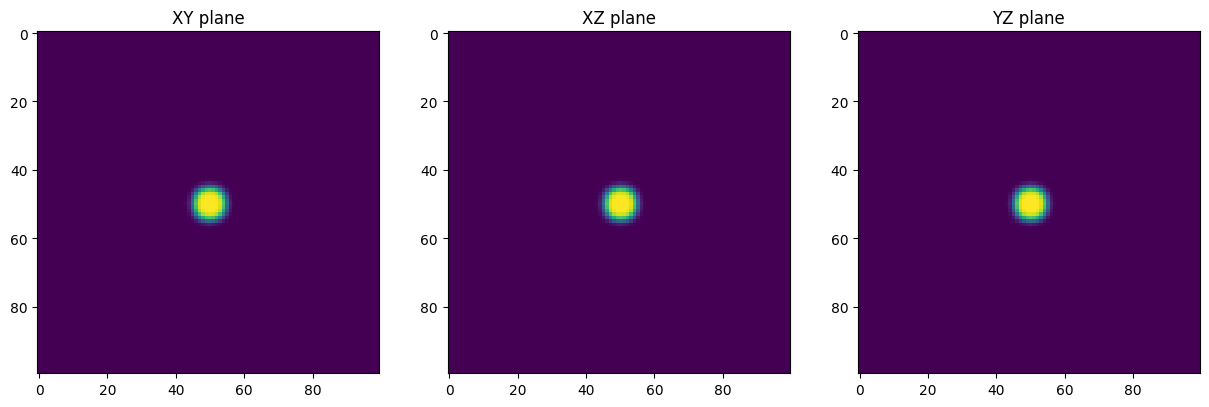

In [88]:
for i in range(filtered_oh_tensor.shape[0]):
    channel = filtered_oh_tensor[i]
    
    xy_slice = get_central_slice(channel, axis = 2)
    xz_slice = get_central_slice(channel, axis = 1)
    yz_slice = get_central_slice(channel, axis = 0)
    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_slice)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_slice)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_slice)
    ax[2].set_title('YZ plane')

### Test Softening on actual Ground Truth

In [4]:
#Loading actual data
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'
train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

# 1. load image 
sample_idx = 3
img_path = train_list[sample_idx]['t1c']
seg_path = train_list[sample_idx]['seg']

img = fnio.load(str(img_path))
seg = fnio.load(str(seg_path))

# 2. transform to torch tensors (and add channel dim to img tensor)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
seg_tensor = torch.tensor(seg, dtype=torch.long)

# 3. transform seg_tensor to one hot encoding and permute the dimensions
oh_seg = F.one_hot(seg_tensor, num_classes=4)
oh_seg = oh_seg.permute(3, 0, 1, 2)

In [5]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 0.5  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_seg = torch.empty_like(oh_seg, dtype=torch.float32)  # Create an empty tensor to store the results

for i in range(oh_seg.shape[0]):  # Loop through each class channel
    filtered_oh_seg[i] = torch.tensor(scipy.ndimage.gaussian_filter(oh_seg[i].numpy().astype(float), sigma=sigma))


print(filtered_oh_seg.shape)  # Should still be (4, x, y, z)
print(f"np.unique(filtered_oh_seg): {np.unique(filtered_oh_seg)}")

torch.Size([4, 240, 240, 155])
np.unique(filtered_oh_seg): [0.0000000e+00 1.8371549e-11 3.6743098e-11 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]


#### Plots

In [6]:
xy_img_slice = get_central_slice(img_tensor, axis = 2)
xz_img_slice = get_central_slice(img_tensor, axis = 1)
yz_img_slice = get_central_slice(img_tensor, axis = 0)

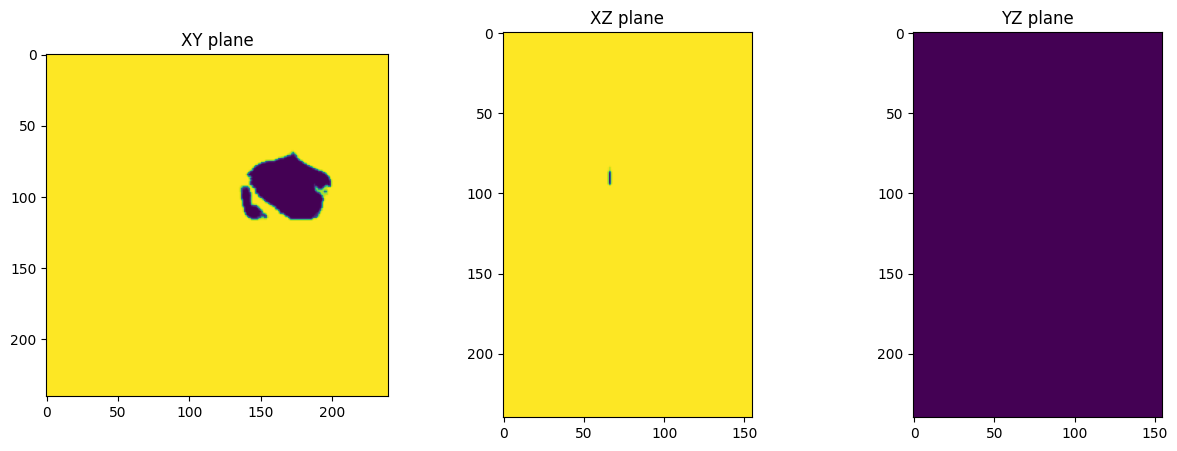

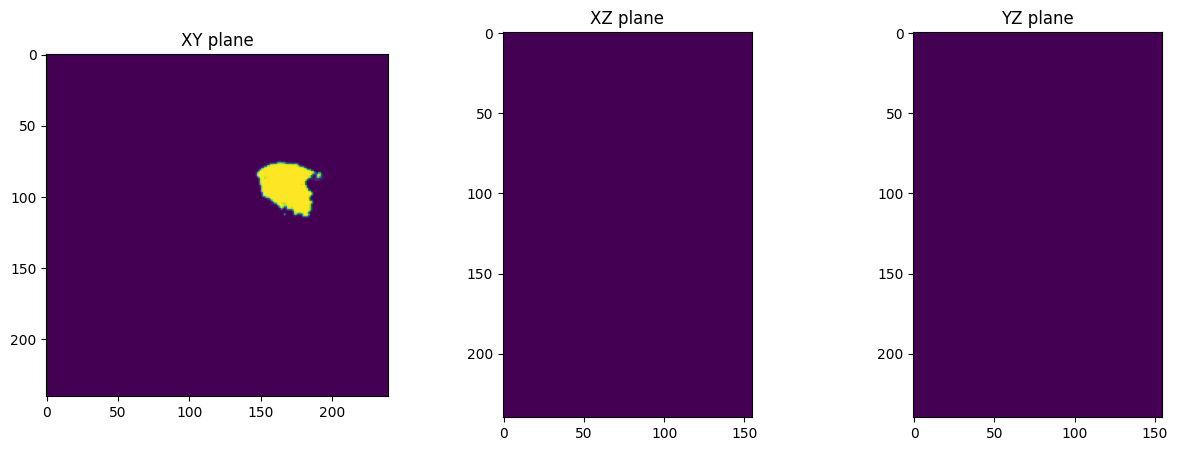

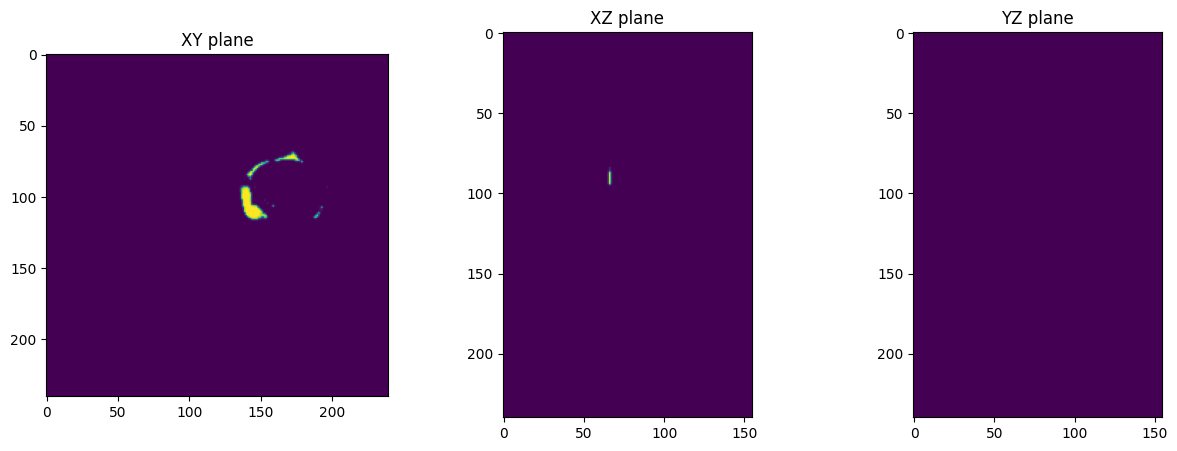

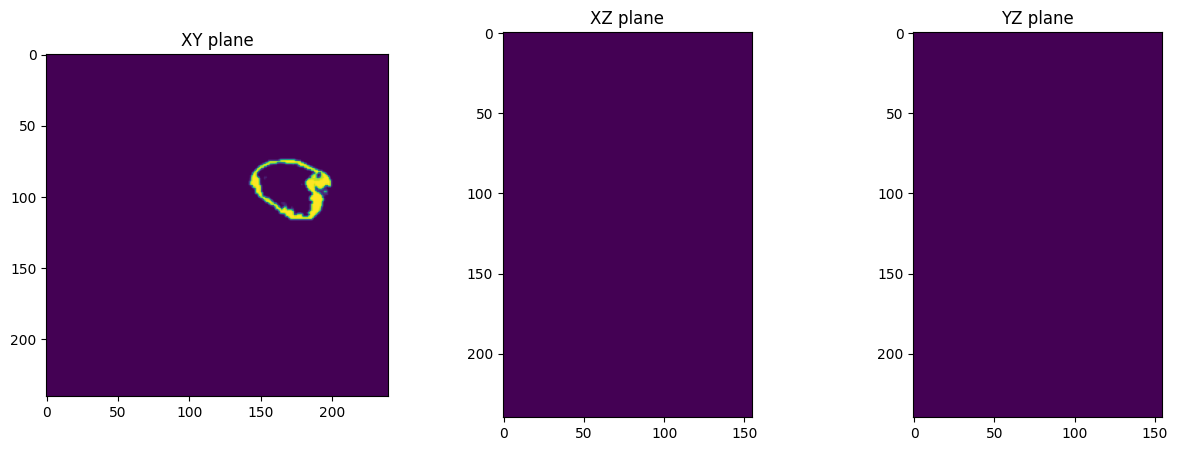

In [7]:
# Plot only segmentation masks
for i in range(filtered_oh_seg.shape[0]):
    channel = filtered_oh_seg[i]

    xy_seg_slice = get_central_slice(channel, axis = 2)
    xz_seg_slice = get_central_slice(channel, axis = 1)
    yz_seg_slice = get_central_slice(channel, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_seg_slice)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_seg_slice)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_seg_slice)
    ax[2].set_title('YZ plane')

####################################
/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/src/utils/brats_tools.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  ax[0].imshow(mri_slice.T, cmap=cmap_mri, origin='lower')
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_ins

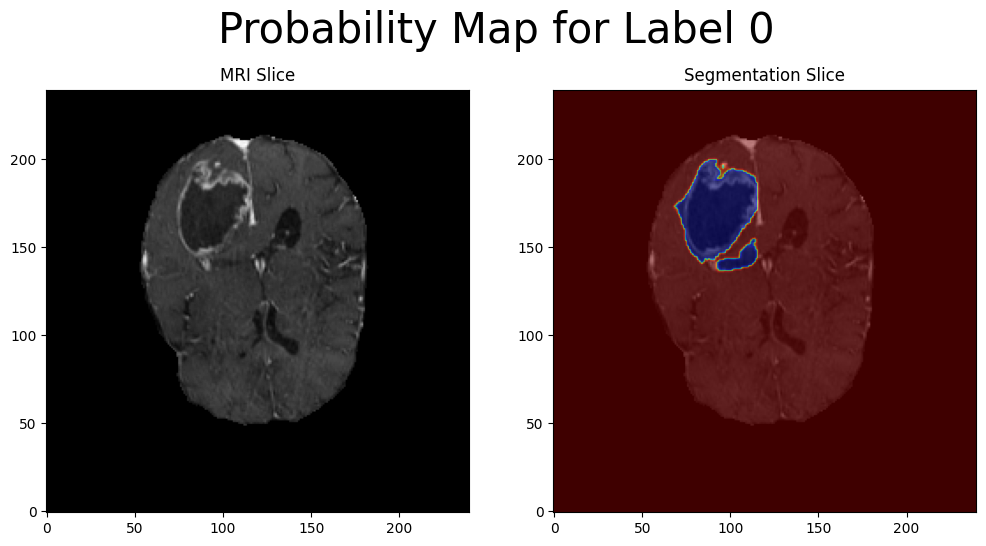

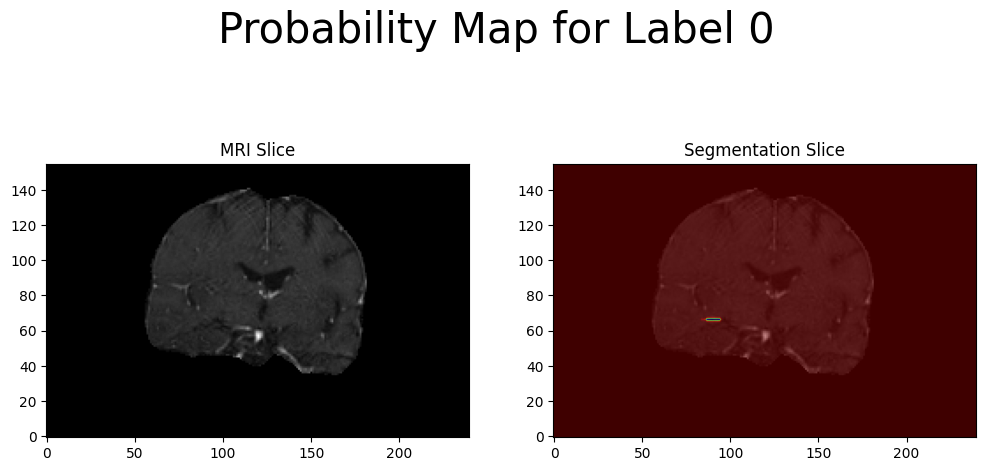

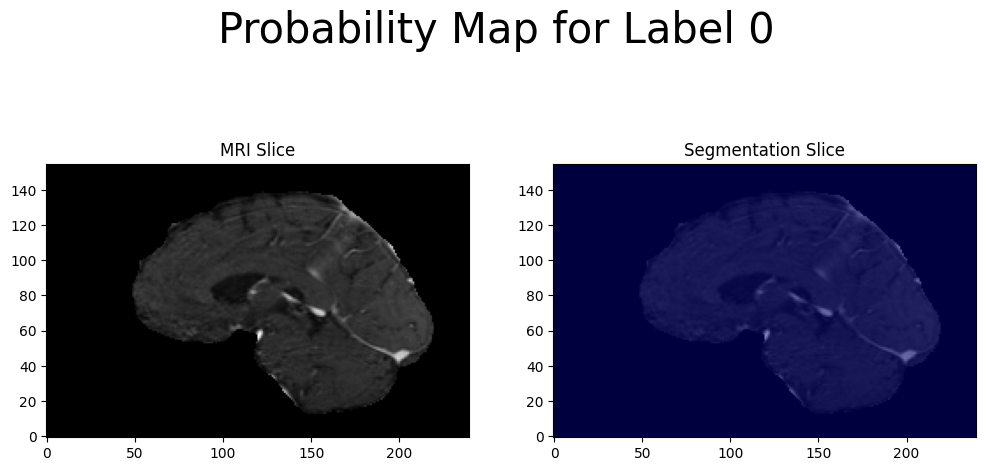

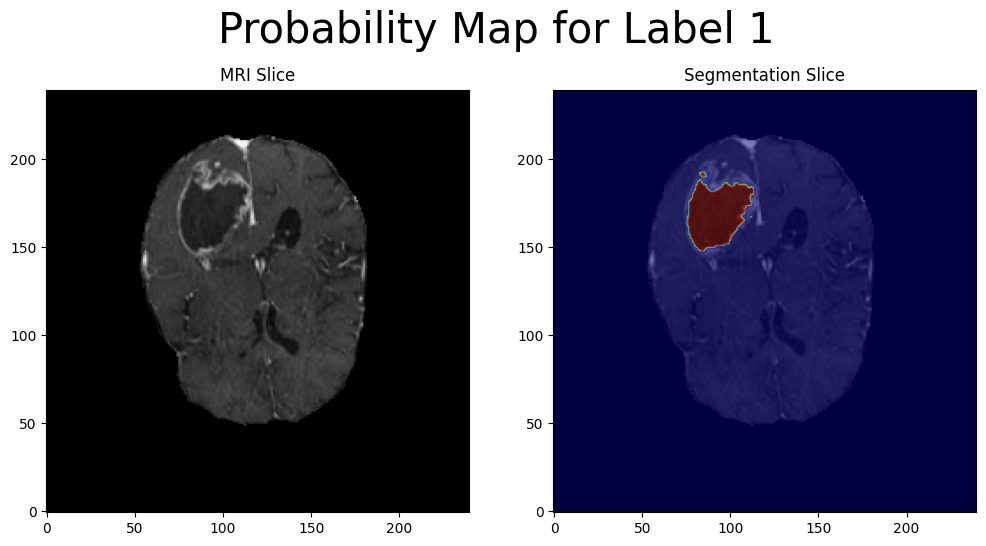

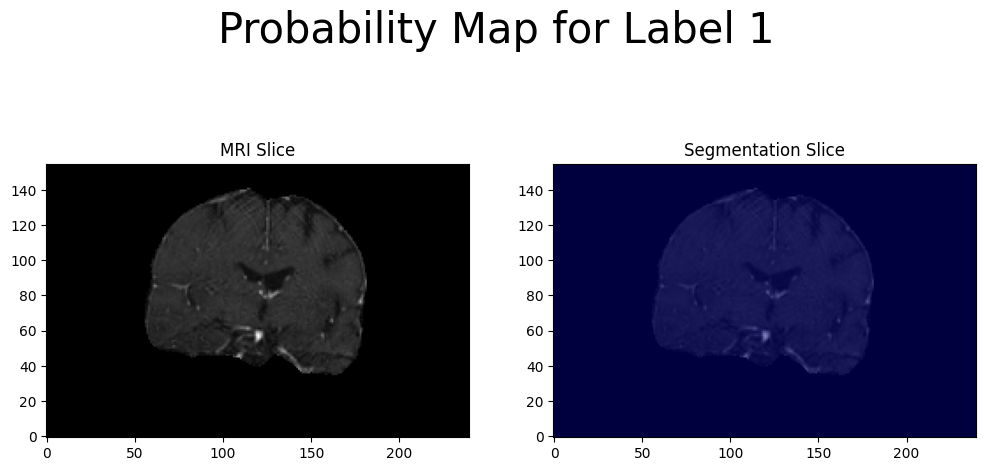

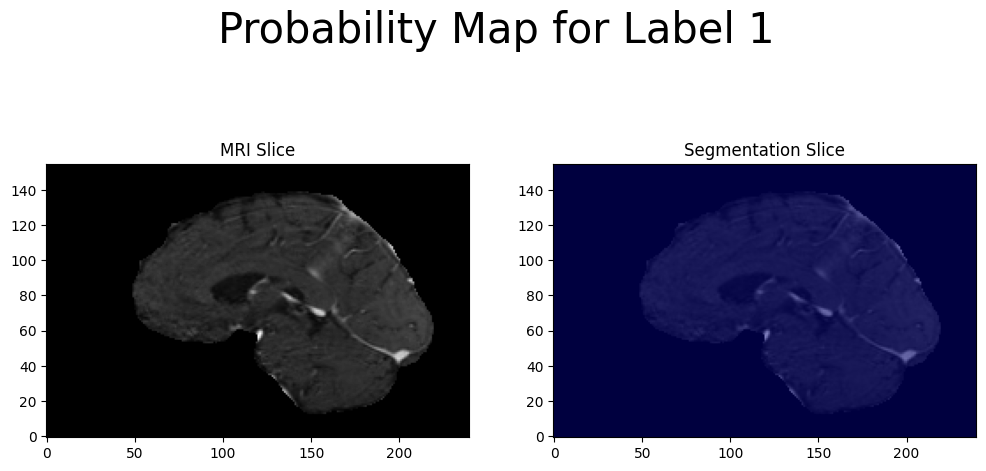

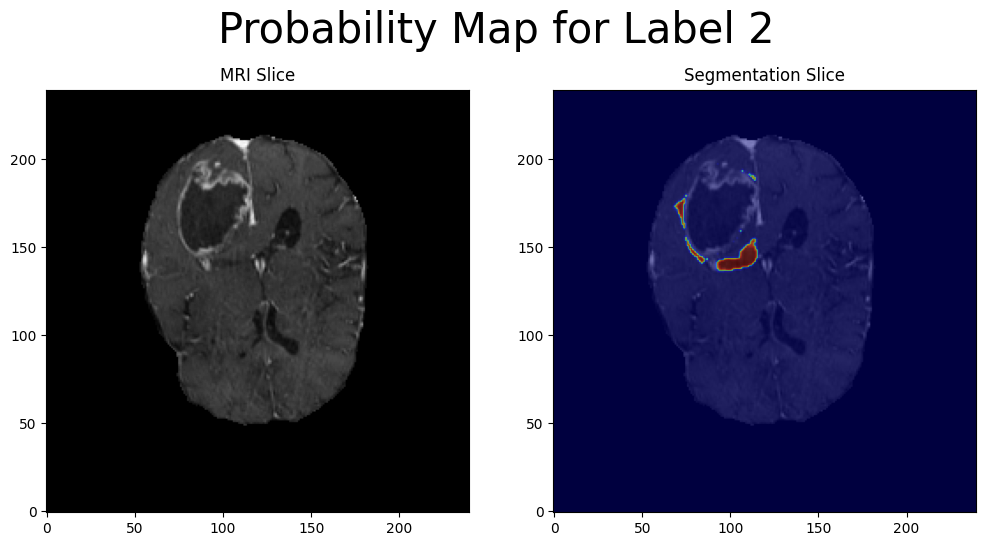

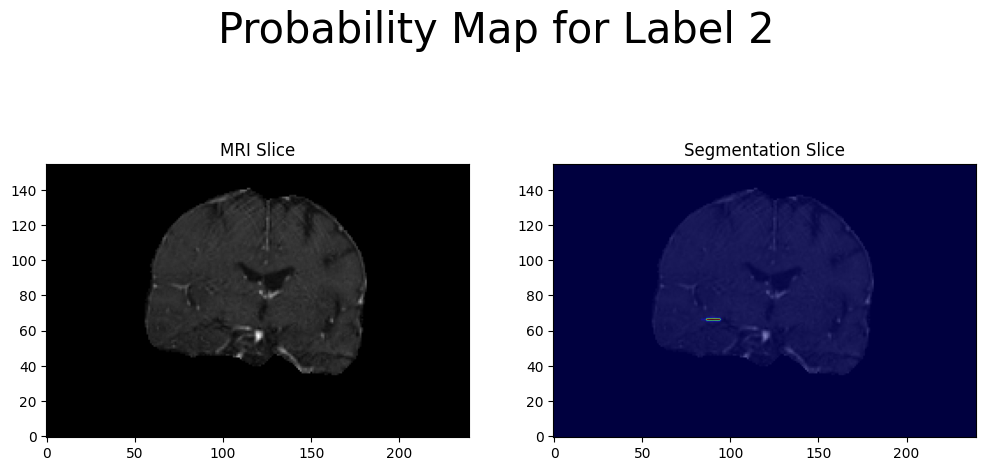

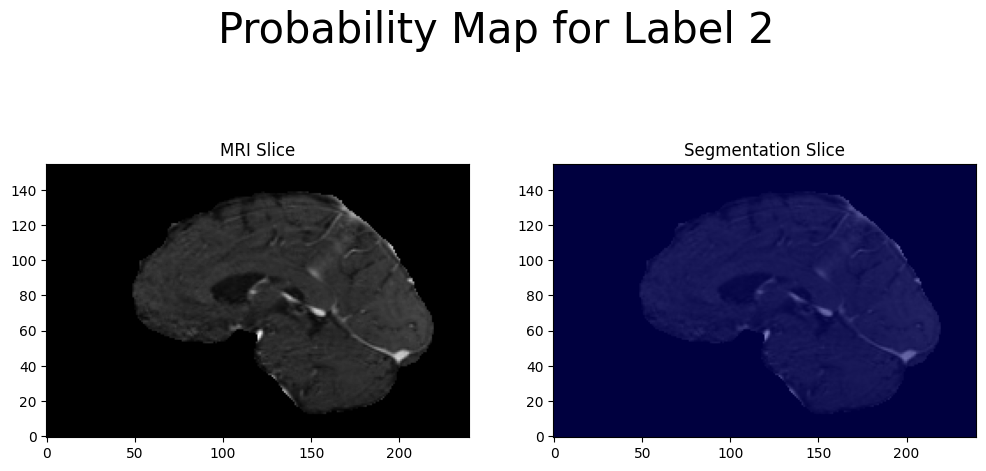

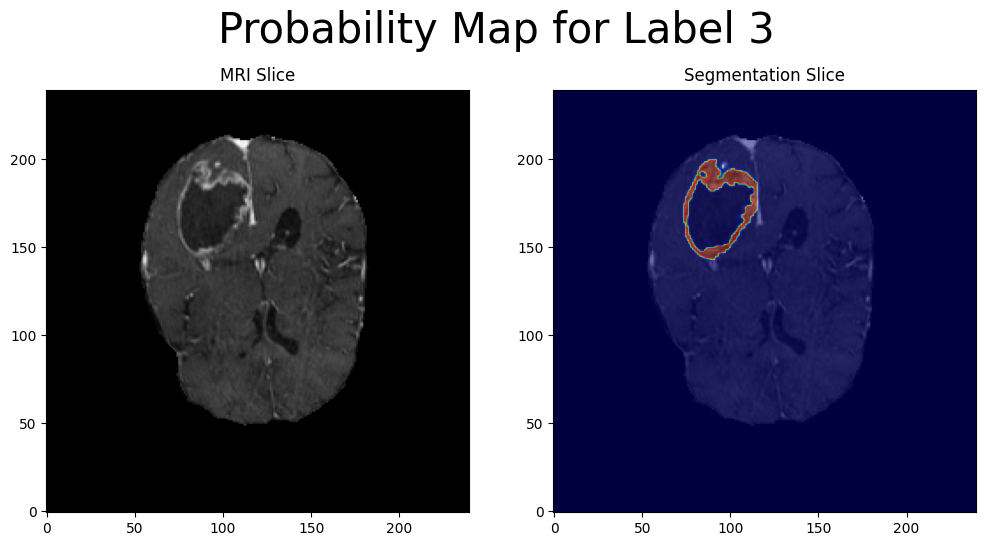

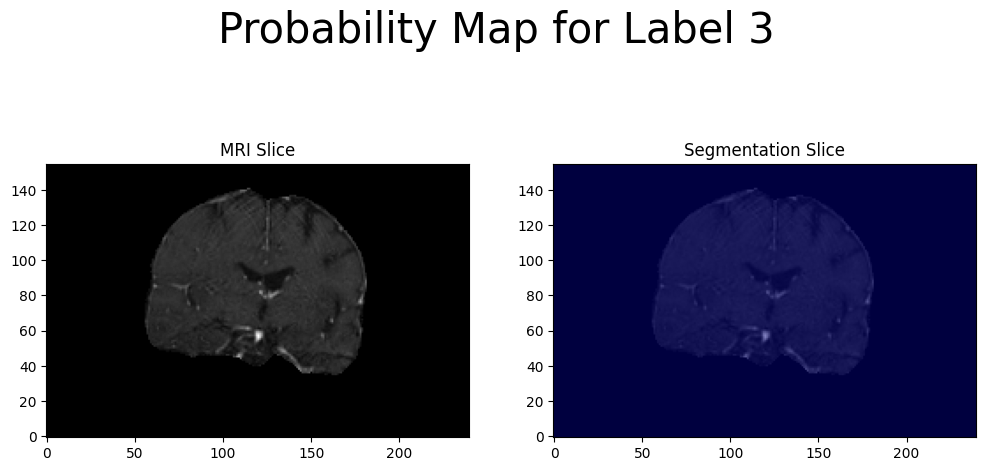

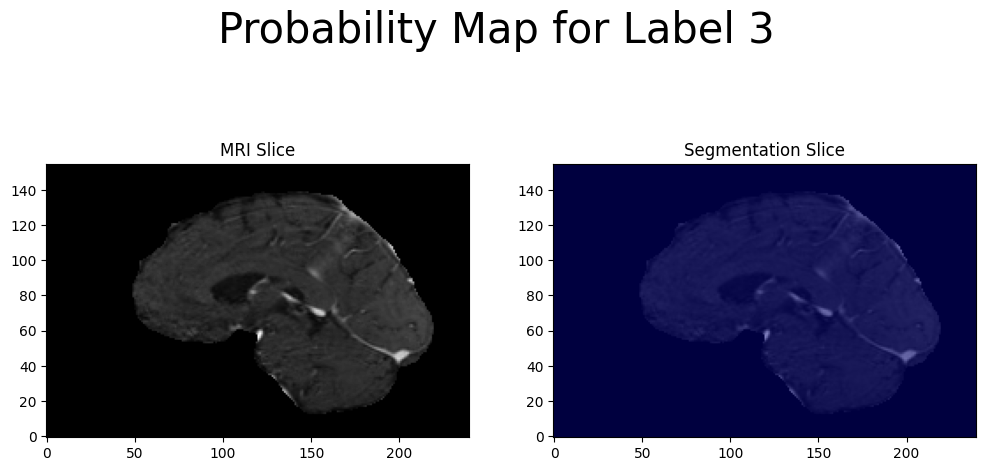

In [8]:
# Plot overlaid masks 

for i in range(filtered_oh_seg.shape[0]):
    channel = filtered_oh_seg[i]

    xy_seg_slice = get_central_slice(channel, axis = 2)
    xz_seg_slice = get_central_slice(channel, axis = 1)
    yz_seg_slice = get_central_slice(channel, axis = 0)

    plot_slices(xy_img_slice, xy_seg_slice, omit_background=False, plt_title='Probability Map for Label ' + str(i))
    plot_slices(xz_img_slice, xz_seg_slice, omit_background=False, plt_title='Probability Map for Label ' + str(i))
    plot_slices(yz_img_slice, yz_seg_slice, omit_background=False, plt_title='Probability Map for Label ' + str(i))